# Q 7 - VQ VAE (Vector Quantized Variational Autoencoder)

Question: Implement a VQ-VAE with discrete latent space. Perform posterior inference on all the images, post-training. Build a classifier with these latent
vectors and calculate the accuracy.

Original paper [Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937)

Helpful videos:
- https://www.youtube.com/watch?v=updRZIvaqCY
- https://www.youtube.com/watch?v=VZFVUrYcig0
- https://www.youtube.com/watch?v=yQvELPjmyn0
- https://www.youtube.com/watch?v=1ZHzAOutcnw&t=36s

### Main difference between VQ VAE and VAE is:
- Latent space is discrete instead of continuous
- Learning a prior distribution rather than a static prior $p(z)$

### Problems with VAE:
- Messy latent space
  The yellow dots may be points that are similar to each other but they occupy different space in the latent space - becaue auto encoders force a static probabilistic prior

![Neural Discrete Representation Learning_ Introducing VQ-VAE.jpeg](<attachment:Neural Discrete Representation Learning_ Introducing VQ-VAE.jpeg>)
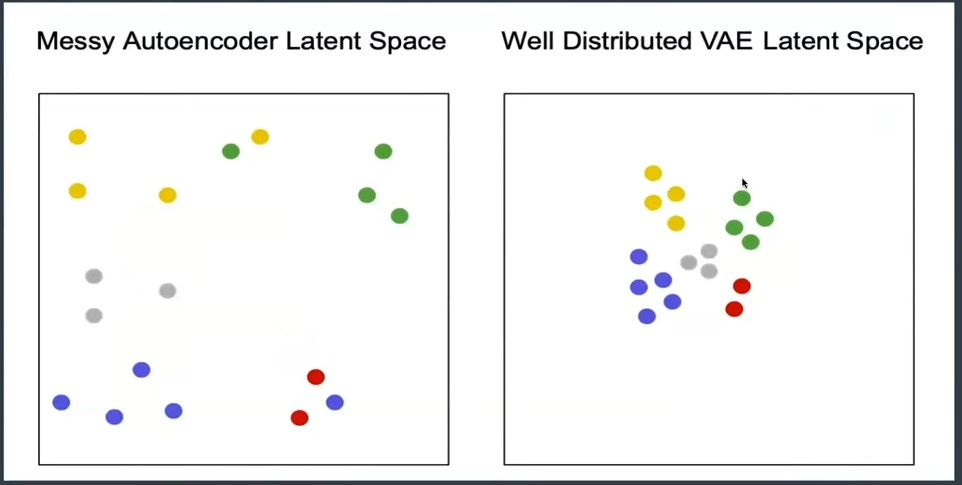

- Also in VAE we enforce a standard normal distribution on $p(z)$, which may not always be the best prior for all types of data that could have many modes. This can lead to suboptimal latent representations and limit the model's ability to capture complex data distributions.

## Hyperparameters

In [1]:
# Defining hyperparameters
dimension_of_codebook_vectors = 128 # Dimension of the codebook vectors ie D
number_of_codebook_vectors = 1024 # Number of codebook vectors ie K
Commitment_cost = 1
num_epochs = 50  # Number of training epochs, determines how long the model will train
batch_size = 64  # Number of samples per gradient update, affects training speed and stability
learning_rate = 0.001  # Learning rate for the optimizer, controls the step size during optimization

## Prelimnaries

In [57]:
# Importing the necessary libraries
import torch  # Import PyTorch library
import torch.nn as nn  # Import neural network module
import torch.optim as optim  # Import optimization module
from torchvision import datasets, transforms  # Import datasets and transforms
from torchvision.utils import save_image, make_grid  # Import utility to save images
import torchvision  # Import torchvision library
import matplotlib.pyplot as plt  # Import plotting library
import os  # Import os module for file operations
import numpy as np  # Import numpy library
import torch.nn.functional as F  # Import the functional module from torch.nn to use F.mse_loss
import torch  # Import PyTorch library for deep learning operations
from torch.utils.data import Dataset  # Import Dataset class from PyTorch for creating custom datasets
import os  # Import os module for file and directory operations
from PIL import Image  # Import Image class from PIL (Python Imaging Library) for image processing
from torchvision import transforms  # Import transforms module from torchvision for image transformations
import os  # Import the os module for directory operations
from sklearn.decomposition import PCA  # Import PCA class from scikit-learn
import numpy as np
from scipy.stats import multivariate_normal
import numpy as np
import torch
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt  # Import matplotlib for visualization
import torch  # Import torch for tensor operations
import joblib  # Import joblib to load the saved PCA model
from sklearn.decomposition import PCA  # Import PCA from sklearn for type hinting
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device
print(f"Using device: {device}")  # Print the device being used

Using device: cuda


## Define models
The complete architecture looks like this:

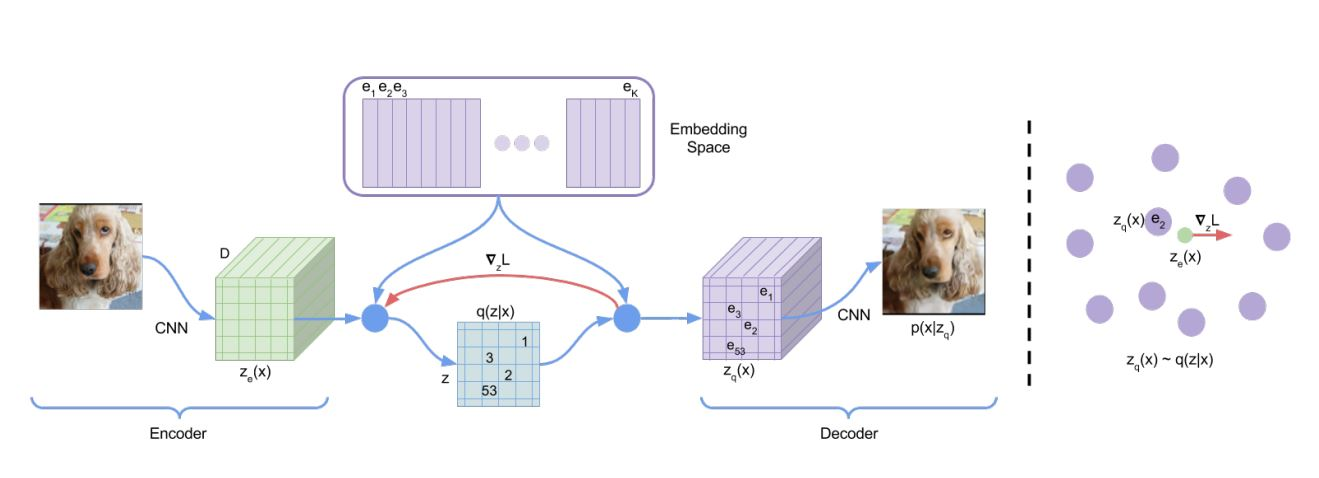

### Encoder
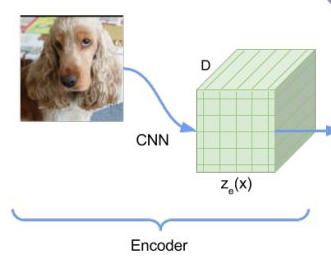

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),  # Input: N x 3 x 128 x 128, Output: N x 64 x 64 x 64, 64 filters of size 4x4x3
            nn.LeakyReLU(0.2),  # Applies Leaky ReLU activation function with negative slope of 0.2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),  # Input: N x 64 x 64 x 64, Output: N x 128 x 32 x 32, 128 filters of size 4x4x64
            nn.BatchNorm2d(128),  # Applies Batch Normalization to the output of the previous layer
            nn.LeakyReLU(0.2),  # Applies Leaky ReLU activation function with negative slope of 0.2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),  # Input: N x 128 x 32 x 32, Output: N x 256 x 16 x 16, 256 filters of size 4x4x128
            nn.BatchNorm2d(256),  # Applies Batch Normalization to the output of the previous layer
            nn.LeakyReLU(0.2),  # Applies Leaky ReLU activation function with negative slope of 0.2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),  # Input: N x 256 x 16 x 16, Output: N x 512 x 8 x 8, 512 filters of size 4x4x256
            nn.BatchNorm2d(512),  # Applies Batch Normalization to the output of the previous layer
            nn.LeakyReLU(0.2),  # Applies Leaky ReLU activation function with negative slope of 0.2
        )
        
        self.final_conv = nn.Conv2d(in_channels=512, out_channels=latent_dim, kernel_size=3, stride=1, padding=1)  # Input: N x 512 x 8 x 8, Output: N x latent_dim x 8 x 8, latent_dim filters of size 3x3x512
    
    def forward(self, x):
        encoded = self.encoder(x)  # Apply main encoder layers
        latents = self.final_conv(encoded)  # Generate latent vectors
        return latents

### Vector Quantizer
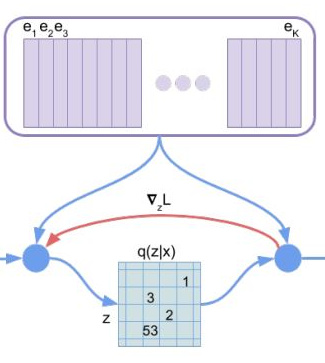

In [11]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self.embedding_dim = embedding_dim  # Dimension of each embedding vector
        self.num_embeddings = num_embeddings  # Number of embedding vectors in the codebook
        self.commitment_cost = commitment_cost  # Coefficient for the commitment loss
        
        # Initialize the embedding vectors (codebook)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)  # Creates an embedding layer to store the codebook
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)  # Initialize embedding weights uniformly

    def forward(self, inputs):
        # Convert inputs from BCHW to BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # Rearrange dimensions from BCHW to BHWC
        
        input_shape = inputs.shape  # Store original input shape
        
        # Reshape inputs to (batch_size * height * width, channels)
        flat_input = inputs.view(-1, self.embedding_dim)  # Flatten input to 2D tensor
        
        # Compute L2 distances between flattened input and embedding vectors
        distances = torch.sum(flat_input**2, dim=1, keepdim=True) + \
                    torch.sum(self.embedding.weight**2, dim=1) - \
                    2 * torch.matmul(flat_input, self.embedding.weight.t())  # Calculate distances using the formula: ||x-y||^2 = ||x||^2 + ||y||^2 - 2x^T y
        
        # Find nearest embedding for each input vector
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # Find index of nearest embedding for each input vector
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)  # Create one-hot encodings
        encodings.scatter_(1, encoding_indices, 1)  # Set the corresponding index to 1 for each encoding
        
        # Quantize the input vectors
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)  # Multiply encodings with embedding weights and reshape to original input shape
        
        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized.detach(), inputs)  # Commitment loss: how far are the inputs from their quantized values
        embedding_loss = F.mse_loss(quantized, inputs.detach())  # Embedding loss: how far are the quantized values from the inputs
        vq_loss = embedding_loss + self.commitment_cost * commitment_loss  # Total VQ loss
        
        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()  # Add quantization error to input (detached to avoid backpropagation through this path)
        
        # Convert quantized from BHWC back to BCHW
        quantized = quantized.permute(0, 3, 1, 2).contiguous()  # Rearrange dimensions from BHWC back to BCHW
        
        # Compute perplexity
        avg_probs = torch.mean(encodings, dim=0)  # Average probability of each encoding across the batch
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))  # Compute perplexity (add small epsilon to avoid log(0))
        
        return vq_loss, quantized, perplexity, encodings  # Return VQ loss, quantized vectors, perplexity, and encodings

### Decoder


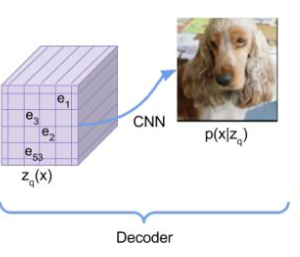

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim  # Store the latent dimension for use in the forward pass
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=4, stride=2, padding=1),  # Input: N x latent_dim x 8 x 8, Output: N x 64 x 16 x 16, 64 filters of size 4x4xlatent_dim
            nn.ReLU(),  # Apply ReLU activation to introduce non-linearity
            nn.BatchNorm2d(64),  # Normalize the output to stabilize training
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Input: N x 64 x 16 x 16, Output: N x 32 x 32 x 32, 32 filters of size 4x4x64
            nn.ReLU(),  # Apply ReLU activation to introduce non-linearity
            nn.BatchNorm2d(32),  # Normalize the output to stabilize training
            
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Input: N x 32 x 32 x 32, Output: N x 16 x 64 x 64, 16 filters of size 4x4x32
            nn.ReLU(),  # Apply ReLU activation to introduce non-linearity
            nn.BatchNorm2d(16),  # Normalize the output to stabilize training
            
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),  # Input: N x 16 x 64 x 64, Output: N x 3 x 128 x 128, 3 filters of size 4x4x16
            nn.Sigmoid()  # Apply Sigmoid activation to ensure output is in range [0, 1]
        )
    
    def forward(self, x):
        decoded_image = self.decoder(x)  # Pass the input through the decoder layers
        return decoded_image  # Return the decoded RGB image

### Complete VQ VAE Model

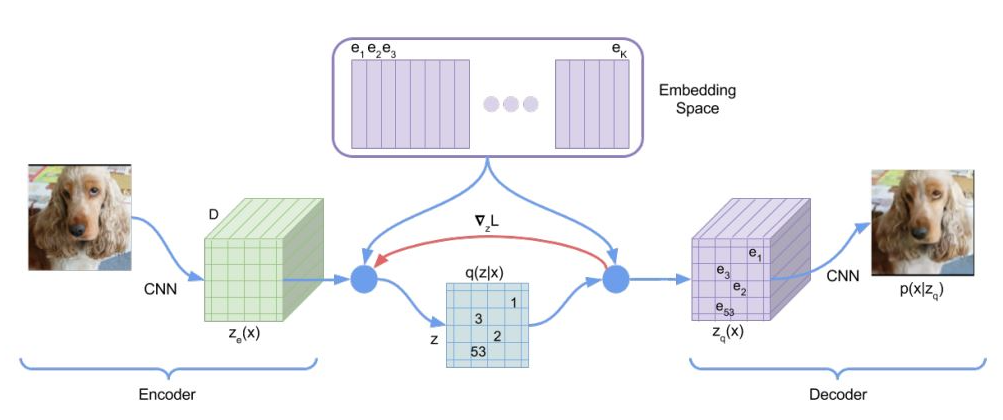

In [13]:
class VQVAE(nn.Module):
    def __init__(self, embedding_dim, num_embeddings=512, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        
        self.encoder = Encoder(embedding_dim)  # Initialize the encoder with the embedding dimension as latent dimension
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)  # Initialize the Vector Quantizer with default or provided values
        self.decoder = Decoder(embedding_dim)  # Initialize the decoder with the embedding dimension
        
    def forward(self, x):
        z = self.encoder(x)  # Encode the input
        vq_loss, quantized, perplexity, _ = self.vq_layer(z)  # Apply Vector Quantization     
        x_recon = self.decoder(quantized)  # Decode the quantized representation
        
        return vq_loss, x_recon, perplexity  # Return VQ loss, reconstructed image, and perplexity


## Define the loss function

The loss function for the VQ-VAE model is defined as:

$L = \underbrace{\|x - D(e_k)\|_2^2}_{\text{reconstruction loss}} + \underbrace{\|\text{sg}[E(x)] - e_k\|_2^2}_{\text{VQ loss}} + \beta\underbrace{\|E(x) - \text{sg}[e_k]\|_2^2}_{\text{commitment loss}}$

Where:
- $x$ is the input
- $E(x)$ is the output of the encoder
- $e_k$ is the closest embedding in the codebook
- $D(e_k)$ is the output of the decoder
- $\text{sg}[]$ denotes the stop-gradient operator
- $\beta$ is the commitment cost

This loss function consists of three components:
1. Reconstruction loss: Measures how well the model reconstructs the input
2. VQ loss: Encourages the embeddings to be close to the encoder outputs
3. Commitment loss: Encourages the encoder to commit to an embedding


*Note that all the loss definations have been defined in respective classes

## Data preparation

In [15]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128 pixels
    transforms.ToTensor(),  # Convert the PIL Image to a tensor, scales to [0, 1]
])

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Directory containing all images
        self.transform = transform  # Transformations to apply to images
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]  # List all image files

    def __len__(self):
        return len(self.image_files)  # Return the total number of images

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])  # Get path of image at index idx
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        
        if self.transform:
            image = self.transform(image)  # Apply transformations if any
        
        return image, 0  # Return image and a dummy label (0)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128 pixels
    transforms.ToTensor(),  # Convert the PIL Image to a tensor, scales to [0, 1]
])

In [17]:
# Load the Butterfly dataset from local machine
data_dir = r'D:\Users\VICTOR\Desktop\ADRL\Assignment 2\Butterfly dataset'  # Path to the Butterfly dataset

# Create dataset and dataloader
dataset = CustomImageDataset(root_dir=data_dir, transform=transform)  # Use our custom dataset class
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Create dataloader

print(f"Loaded {len(dataset)} images.")  # Print the total number of images loaded

Loaded 9285 images.


## Training loop


In [39]:
# Create an instance of the VQVAE model using predefined hyperparameters
vqvae = VQVAE(
    embedding_dim=dimension_of_codebook_vectors,  # Dimension of each embedding vector (D) in the codebook
    num_embeddings=number_of_codebook_vectors,  # Number of embedding vectors in the codebook (K)
    commitment_cost=Commitment_cost  # Commitment cost for the loss function
).to(device)  # Move the model to the specified device (CPU or GPU)

print(f"VQVAE model created with {sum(p.numel() for p in vqvae.parameters())} parameters")  # Print the total number of parameters in the model

VQVAE model created with 3652499 parameters


In [40]:
vqvae.train()  # Set the VQVAE model to training mode, enabling gradient computation and batch normalization updates

VQVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2)
    )
    (final_conv): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (vq_layer): VectorQuantizer(
    (embedding): Embedding(1024, 128)
  )
  (decoder): Decoder(


In [41]:
# Define the optimizer for the VQVAE model
optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)  # Create an Adam optimizer with the predefined learning rate for all parameters of the VQVAE model

In [47]:
# Initialize lists to store training metrics
train_res_recon_error = []  # List to store reconstruction errors during training
train_res_perplexity = []  # List to store perplexity values during training

# Compute data variance for normalization
data_variance = torch.var(next(iter(dataloader))[0])  # Calculate variance of the first batch for normalization

for epoch in range(num_epochs):  # Outer loop for epochs
    print(f"Epoch {epoch+1}/{num_epochs}")  # Print current epoch number
    
    for batch_idx, (data, _) in enumerate(dataloader):  # Inner loop for batches
        optimizer.zero_grad()  # Reset the gradients at the start of each batch iteration
        
        data = data.to(device)  # Move the data to the specified device (CPU or GPU)
    
        vq_loss, data_recon, perplexity = vqvae(data)  # Forward pass through the VQVAE model
        recon_error = F.mse_loss(data_recon, data) / data_variance  # Calculate reconstruction error normalized by data variance
        loss = recon_error + vq_loss  # Compute total loss by combining reconstruction error and VQ loss
        loss.backward()  # Perform backward pass to compute gradients

        optimizer.step()  # Update model parameters based on computed gradients
        
        train_res_recon_error.append(recon_error.item())  # Store the reconstruction error for this iteration
        train_res_perplexity.append(perplexity.item())  # Store the perplexity for this iteration

        print(f"Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}")  # Print the current batch number, total number of batches, and loss

        # Save image
        with torch.no_grad():  # Disable gradient computation for inference
            # Select the first image from the batch
            original_image = data[0].cpu()  # Move the image to CPU and keep the original
            reconstructed_image = data_recon[0].cpu()  # Move the reconstructed image to CPU
            
            # Create a figure with two subplots side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row, 2 columns, and set the figure size
            
            # Plot the original image
            ax1.imshow(original_image.permute(1, 2, 0).clip(0, 1))  # Permute dimensions for plotting and clip values between 0 and 1
            ax1.set_title('Original Image')  # Set the title for the original image
            ax1.axis('off')  # Turn off axis for cleaner look
            
            # Plot the reconstructed image
            ax2.imshow(reconstructed_image.permute(1, 2, 0).clip(0, 1))  # Permute dimensions for plotting and clip values between 0 and 1
            ax2.set_title('Reconstructed Image')  # Set the title for the reconstructed image
            ax2.axis('off')  # Turn off axis for cleaner look
            
            # Save the figure
            save_dir = 'reconstructed_images'  # Define the directory to save images
            os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            save_path = os.path.join(save_dir, f'reconstruction_epoch_{epoch+1}.png')  # Create the full path for saving the image
            plt.savefig(save_path)  # Save the figure to the specified path
            plt.close(fig)  # Close the figure to free up memory
            
            print(f'Reconstruction image saved for epoch {epoch+1} in directory: {save_dir}')  # Print confirmation message for image saving


    # Save model at the end of each epoch
    model_save_dir = 'vqvae_models'  # Define the directory name for saving models
    os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist, otherwise do nothing
    model_save_path = os.path.join(model_save_dir, f'vqvae_model_epoch_{epoch+1}.pth')  # Create the full path for saving the model
    torch.save(vqvae.state_dict(), model_save_path)  # Save model state dictionary to the specified path
    print(f'Model saved at epoch {epoch+1} in directory: {model_save_dir}')  # Print confirmation message for model saving with directory information
    print(f'Epoch {epoch+1} completed. Average Loss: {sum(train_res_recon_error[-len(dataloader):]) / len(dataloader):.4f}')  # Print completion message for the epoch with average loss
    print()  # Print an empty line for better readability between epochs

Epoch 1/50
Batch 1/146, Loss: 64.2146
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 2/146, Loss: 56.4973
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 3/146, Loss: 53.9973
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 4/146, Loss: 55.3940
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 5/146, Loss: 56.3811
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 6/146, Loss: 57.8782
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 7/146, Loss: 56.9455
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 8/146, Loss: 57.2325
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 9/146, Loss: 56.1265
Reconstruction image saved for epoch 1 in directory: reconstructed_images
Batch 10/146, Loss: 52.6465
Reconstruction image saved for epoch 1 in directory: